# 使用3层神经网络训练 MNIST 数据集
> 参考《Python神经网络编程（塔里克•拉希德）》（[代码](https://github.com/makeyourownneuralnetwork/makeyourownneuralnetwork/tree/master)）

In [1]:
import os
import time
import numpy as np
import scipy.special
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. 定义网络

* 反向传播计算隐藏层误差：$$ error_{hidden} = weights_{hidden\_output}^{T} \cdot error_{output} $$
* 更新节点j与其下一层节点k之间链接权重的矩阵表达式：$$ \Delta\omega = \alpha * E_{k} * sigmoid(O_{k}) * (1 - sigmoid(O_{k}) \cdot O_{j}^{T} $$

In [2]:
class Net:

    def __init__(self, input_node_num, hidden_node_num, output_node_num, learning_rate):
        """
        初始化
        """
        # 设置输入层节点数、隐藏层节点数、输出层节点数
        self.input_node_num = input_node_num
        self.hidden_node_num = hidden_node_num
        self.output_node_num = output_node_num

        # 链接权重矩阵。使用正态概率分布采样权重，其中均值为0，标准差为节点传入链接数目的开方，即 1/(传入链接数目^0.5)
        self.wih = np.random.normal(0.0, pow(self.hidden_node_num, -0.5), (self.hidden_node_num, self.input_node_num))
        self.who = np.random.normal(0.0, pow(self.output_node_num, -0.5), (self.output_node_num, self.hidden_node_num))

        # 学习率
        self.lr = learning_rate

        # 激活函数。使用 Sigmoid
        self.activation_function = lambda x : scipy.special.expit(x)
        # 反激活函数。Sigmoid 的反函数是 Logit
        self.inverse_activation_function = lambda x: scipy.special.logit(x)

    def train(self, inputs_list, target_list):
        """
        训练
        """
        # 将输入、结果转换为二维数组，并转置
        # ndmin 表示最小维度数。如果输入数据的维度少于 ndmin 指定的值，则会在前面添加新的轴以达到指定的最小维度数
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(target_list,ndmin=2).T

        # 计算隐藏层输入值
        hidden_inputs = np.dot(self.wih, inputs)
        # 计算隐藏层输出值
        hidden_outputs = self.activation_function(hidden_inputs)

        # 计算最后一层输入值
        final_inputs = np.dot(self.who, hidden_outputs)
        # 计算最后一输出值
        final_outputs = self.activation_function(final_inputs)

        # 计算输出层误差
        output_errors = targets - final_outputs
        # 计算隐藏层误差。根据权重分配
        hidden_errors = np.dot(self.who.T, output_errors)

        # 更新隐藏层与输出层之间的误差
        self.who += self.lr * np.dot(output_errors * final_outputs * (1 - final_outputs), np.transpose(hidden_outputs))
        # 更新输入层与隐藏层之间的误差
        self.wih += self.lr * np.dot(hidden_errors * hidden_outputs * (1 - hidden_outputs), np.transpose(inputs))
        
    def query(self, inputs_list):
        """
        查询
        """
        # 将输入、结果转换为二维数组，并转置
        inputs = np.array(inputs_list, ndmin=2).T

        # 计算隐藏层输入值
        hidden_inputs = np.dot(self.wih, inputs)
        # 计算隐藏层输出值
        hidden_outputs = self.activation_function(hidden_inputs)

        # 计算最后一层输入值
        final_inputs = np.dot(self.who, hidden_outputs)
        # 计算最后一输出值
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

    def backquery(self, target_list):
        """
        反向查询
        """
        # 将输结果转换为二维数组，并转置
        final_outputs = np.array(target_list, ndmin=2).T
        # 计算最后一层输入值
        final_inputs = self.inverse_activation_function(final_outputs)
        
        # 计算隐藏层的输出值
        hidden_outputs = np.dot(self.who.T, final_inputs)
        # 将隐藏层输出值范围调整到 [0.01, 0.99]，即 Logit 函数的输入值范围
        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # 计算隐藏层的输入值
        hidden_inputs = self.inverse_activation_function(hidden_outputs)

        # 计算输入层的值
        inputs = np.dot(self.wih.T, hidden_inputs)
        # 将输入层输出值范围调整到 [0.01, 0.99]
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs


## 2. 数据集
* 下载地址：[Kaggle mnist-in-csv](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv/data)

In [3]:
# 下载
# import kagglehub

# path = kagglehub.dataset_download("oddrationale/mnist-in-csv")
# print("Path to dataset files:", path)

In [4]:
train_file_path = os.getcwd() + '/Documents/work-jupyter/py37_maching_learning/ann/mnist/mnist_train.csv'
test_file_path = os.getcwd() + '/Documents/work-jupyter/py37_maching_learning/ann/mnist/mnist_test.csv'

In [5]:
# 样本格式。第一列：标签。第二列到最后一列：特征
df_train = pd.read_csv(train_file_path)
df_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


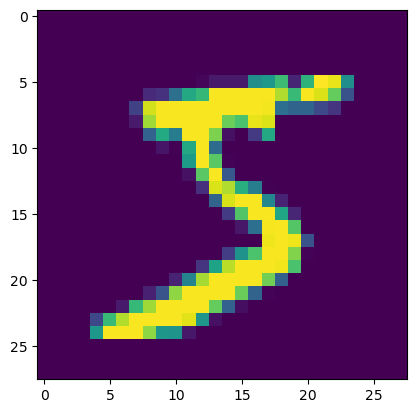

In [6]:
# 第一个样本的特征
image = np.array(df_train.iloc[0][1:].tolist()).reshape(28, 28)
plt.imshow(image)
plt.show()

## 3. 训练

In [7]:
# 定义输入层、隐藏层、输出层节点数
input_node_num = 784
hidden_node_num = 200
output_node_num = 10

# 学习率
learning_rate = 0.1

# 创建神经网络实例
net = Net(input_node_num, hidden_node_num, output_node_num, learning_rate)
print('创建神经网络实例:', net)

# 加载训练集
training_data_file = open(train_file_path)
training_data_list = training_data_file.readlines()
training_data_file.close()
training_data_list = training_data_list[1:]  # 排除第一行标题
print('加载训练集数量:', len(training_data_list))

创建神经网络实例: <__main__.Net object at 0x122ce7c80>
加载训练集数量: 60000


In [ ]:
# 训练神经网络
epochs = 5  # 训练轮数
for epoch in range(epochs):
    start_time = time.time()
    for record in training_data_list:
        # csv 文件，逗号分割的格式
        all_values = record.split(',')
        # 特征值值。将特征值 [0, 255] 调整到 [0.01, 0.99]
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # 目标值。将目标值设置为 0.01 或 0.99。注意，不要设置成激活函数达到不了的值
        targets = np.zeros(output_node_num) + 0.01
        targets[int(all_values[0])] = 0.99
        net.train(inputs, targets)
    end_time = time.time()
    print('第{}论训练完成，耗时{}秒'.format(epoch + 1, end_time - start_time))


第1论训练完成，耗时52.278841733932495秒


## 4. 测试

In [ ]:
# 加载测试集
test_data_file = open(test_file_path)
test_data_list = test_data_file.readlines()
test_data_file.close()
test_data_list = training_data_list[1:]  # 排除第一行标题

# 准确率
scorecard = []
for record in test_data_list:
    # csv 文件，逗号分割的格式
    all_values = record.split(',')
    # 特征值值。将特征值 [0, 255] 调整到 [0.01, 0.99]
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # 正确标签
    correct_label = int(all_values[0])
    # 网络实际输出值
    outputs = net.query(inputs)
    # 选取输出值中最大的索引作为预测标签
    predit_label = np.argmax(outputs)
    if correct_label == predit_label:  # 预测正确
        scorecard.append(1)
    else:  # 预测错误
        scorecard.append(0)

# 计算预测的准确率
scorecard_array = np.array(scorecard)
print('preformance = ', scorecard_array.sum()/scorecard_array.size)


## 5. 向后查询

In [ ]:
plt.figure(figsize=(6, 3), dpi=100)
for label in range(0, 10):
    # 初始化输出值
    targets = np.zeros(output_node_num) + 0.01
    # 设置标签值
    targets[label] = 0.99

    # 反向查询生成图像数据
    image_data = net.backquery(targets)
    plt.subplot(2, 5, label + 1)
    plt.title(label + 1)
    plt.imshow(image_data.reshape(28, 28), cmap='Greys', interpolation='None')
plt.show()
